In [1]:
import ai2thor
from ai2thor.controller import Controller,BFSController
from ai2thor.platform import CloudRendering
import torch

from ithor_tools.vis_tool import *
from ithor_tools.transform import cornerpoint_projection,attn2map
from ithor_tools.map import single_scenemap

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
gridSize=0.05
scene_name = "FloorPlan_Train1_2"
controller = Controller(
    agentMode="locobot",
    visibilityDistance=2.0,
    scene = scene_name,
    gridSize=gridSize,
    movementGaussianSigma=0,
    rotateStepDegrees=90,
    rotateGaussianSigma=0,
    renderClassImage = True,
    renderDepthImage=True,
    renderInstanceSegmentation=False,
    width=300,
    height=300,
    fieldOfView=60
)

controller.reset(
    # makes the images a bit higher quality
    width=800,
    height=800,

    # Renders several new image modalities
    renderDepthImage=True,
    renderClassImage = True,
    renderSemanticSegmentation=False,
    renderNormalsImage=False
)
scene_bounds = controller.last_event.metadata['sceneBounds']['center']

controller.step(
    action="AddThirdPartyCamera",
    position=dict(x=scene_bounds['x'], y=5.0, z=scene_bounds['z']),
    rotation=dict(x=90, y=0, z=0),
    orthographic=True,
    orthographicSize= 5.0, fieldOfView=100,
    skyboxColor="white"
)
controller.step(dict(action='GetReachablePositions'))
rstate = controller.last_event.metadata['actionReturn']

controller.step(
    action="Teleport",
    position = rstate[200],
    rotation = dict(x=0,y=270,z=0)
)



INFO - 2022-06-01 22:51:56,621 - controller - Initialize return: {'cameraNearPlane': 0.10000000149011612, 'cameraFarPlane': 20.0}


<ai2thor.server.Event at 0x7f039ece9b50
    .metadata["lastAction"] = Teleport
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = None
>

0.6868000030517578 10.446799278259277 -5.351839542388916 0.5981607437133789
(98, 59)
(418, 713, 3)


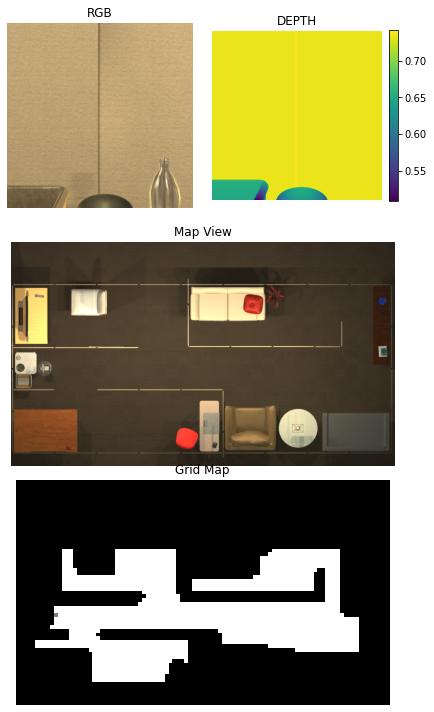

In [3]:
controller.step(
    action="Teleport",
    position = rstate[200],
    rotation = dict(x=0,y=270,z=0)
)

scene_bounds = controller.last_event.metadata['sceneBounds']['cornerPoints']
scene_bounds = cornerpoint_projection(scene_bounds)
sm = single_scenemap(scene_bounds,rstate,stepsize = 0.1)

pos = controller.last_event.metadata['agent']['position']
imshow_grid = sm.plot(pos)
plot_frames(controller.last_event,imshow_grid)

In [4]:
from FBE.fbe import gridmap

fbe = gridmap(scene_bounds)

0.6868000030517578 10.446799278259277 -5.351839542388916 0.5981607437133789


In [24]:



fbe = gridmap(scene_bounds)

0.6868000030517578 10.446799278259277 -5.351839542388916 0.5981607437133789


### Repeat Below Cell

In [25]:
def step():
    temp_map= fbe.scan_full(controller)
    cpos = controller.last_event.metadata['agent']['position']
    waypoints, indexs = fbe.frontier_detection(cpos)

    grid_cpos = fbe.xyz2grid(cpos)
    fbe.map[grid_cpos[0],grid_cpos[1]] = [0.7,0.7,0]
    # imshow_grid = sm.plot(cpos)
    # plot_frames(controller.last_event,imshow_grid)
    print(waypoints)
    if len(waypoints)> 0:
        for indx in indexs:
            controller.step(
                action="Teleport",
                position = waypoints[indx],
                rotation = dict(x=0,y=270,z=0)
            )
            action_sucess = controller.last_event.metadata['lastActionSuccess']
            if action_sucess:
                grid_pos = fbe.xyz2grid(waypoints[indx])
                fbe.map[grid_pos[0],grid_pos[1]] = [0,0.7,1]
                break
    else:
        print("Done Exploration")

    plt.figure(figsize=(15,7))
    plt.subplot(1,3,1)
    plt.imshow(temp_map)
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(fbe.map)
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(sm.gridmap)
    plt.axis("off")
    plt.show()
    try:
        fbe.map[grid_cpos[0],grid_cpos[1]] = [1,1,1]
        fbe.map[grid_pos[0],grid_pos[1]] = [1,1,1]
    except:
        pass
    

[]
Done Exploration


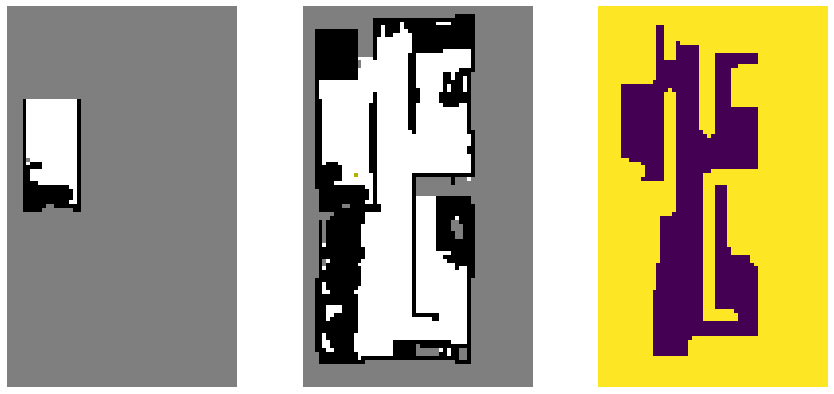

In [36]:
step()